# Lab Assignment Five: Wide and Deep Network Architectures

CS 7324

2021-04-18

Anthony Wang

## Preparation

The [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) dataset contains 10 years of daily weather observations. The associated prediction task is whether there was more than 1mm of rain the following day.

First, all instances containing null data are removed. The date feature is not useful for classification, so it is deleted entirely. The RainToday feature contains redundant data already described by the Rainfall feature, so it is removed as well. Some features ending in "9am", despite not technically being redundant, are likely less valuable than the later 3pm measurements, and their removal will likely be worth the dimensional reduction. Other features such as Humidity, Pressure, and Cloud coverage are more closely linked to the possibility of rain, so having two measurements throughout the day are more likely indicate a trend which continues into the next.

Location will be one-hot encoded. WindGustDir, WindDir9am, and WindDir3pm are cardinal directions, and are one-hot encoded too. The Cloud9am and Cloud3pm features describe the fraction of sky obscured by clouds at their respective times. These two features are measured in eigths and may become a valueable cross-product feature, so they are converted from floats to one-hot encodings. The RainTomorrow feature undergoes a simple conversion from strings to booleans.

The Rainfall does not have a gaussian distribution, so that feaure will be normalized. The remaining continuous features will be standardized.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize

df = pd.read_csv("weatherAUS.csv")

# Remove Date and redundant features
del df["Date"]
del df["RainToday"]
del df["WindDir9am"]
del df["WindSpeed9am"]
del df["Temp9am"]

# Remove null values
df.dropna(inplace=True)
df = df[df.Cloud3pm != 9] # one instance indicates 9/8 of the sky was covered by clouds, which has to be an error

# Convery cloud cover features from float to strings
df["Cloud9am"] = df["Cloud9am"].astype(str)
df["Cloud3pm"] = df["Cloud3pm"].astype(str)

# List categorical features, one hot encoding will be performed later during feature crossing
categorical = ["Location", "WindGustDir", "WindDir3pm", "Cloud9am", "Cloud3pm"]
categorical_int = [s + "_int" for s in categorical]

# Convert "No" and "Yes" objects into booleans
df["RainTomorrow"] = df["RainTomorrow"].map({"No": False, "Yes": True})

# Normalize/standardize numerical features
numerical = ["MinTemp", "MaxTemp", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Temp3pm", "Rainfall"]
scaler = StandardScaler()
df[numerical[:-1]] = scaler.fit_transform(df[numerical[:-1]])
df[[numerical[-1]]] = normalize(df[[numerical[-1]]])

df.reset_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57930 entries, 6049 to 142302
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       57930 non-null  object 
 1   MinTemp        57930 non-null  float64
 2   MaxTemp        57930 non-null  float64
 3   Rainfall       57930 non-null  float64
 4   Evaporation    57930 non-null  float64
 5   Sunshine       57930 non-null  float64
 6   WindGustDir    57930 non-null  object 
 7   WindGustSpeed  57930 non-null  float64
 8   WindDir3pm     57930 non-null  object 
 9   WindSpeed3pm   57930 non-null  float64
 10  Humidity9am    57930 non-null  float64
 11  Humidity3pm    57930 non-null  float64
 12  Pressure9am    57930 non-null  float64
 13  Pressure3pm    57930 non-null  float64
 14  Cloud9am       57930 non-null  object 
 15  Cloud3pm       57930 non-null  object 
 16  Temp3pm        57930 non-null  float64
 17  RainTomorrow   57930 non-null  bool   
dtypes:

The aforementioned WindGustDir and WindDir3pm features should be combined into cross-product features because of their close relation to wind conditions of a given Australian day. The same logic applies to Cloud9am and Cloud3pm and the cloud cover. However, the third model in this analysis will cross all five categorical features in the event there is a relation between them that isn't as obvious as the two described.

In [2]:
# Utility function
def cross_features(columns):
    crossed_columns = []
    for cols_list in cross_columns:
        # Create crossed features
        enc = LabelEncoder()
        X_crossed = df[cols_list].apply(lambda x: '_'.join(x), axis=1)
        # Encode and save crossed features in dataframe
        cross_col_name = '_'.join(cols_list) + '_int'
        df[cross_col_name] = enc.fit_transform(X_crossed)
        # Track new crossed feature name
        crossed_columns.append(cross_col_name)
    return crossed_columns

The model's F-measure will be used to evaluate its performance. Applications of this model are unlikely to care much for how frequently it predicts clear days. Accurate prediction of rainy days is much more likely to be needed. For example in a construction environment, false positives could result in unnecessary precautions or days called off, missiing opporunities to work and delaying progress. On the other hand, false negatives could waste time and money as workers show up to uncooperative conditions.

In [3]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
# Definition of custom f-score function

import keras.backend as K

def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

58,000 is a large number of instances which could provide ample data for training and testing using holdout validation. However, the large number of features creates a high-dimensional search space which may be too large for samples to even populate. Additionally, the classes are imbalanced, with about four times as many negatives as positives. Thus, the data will be divided using stratified 10-fold cross validation. This also ensures training is independent of any subset of the data. Besides, if you have the processing power to spare, why not use stratified k-fold cross validation to squeeze more performance out of a model?

In [4]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

X_num = df[numerical].values
y = df["RainTomorrow"].values

## Modeling

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

# Utility function for plotting model statistics
def plot_histories(histories):
    F1 = []
    val_F1 = []
    loss = []
    val_loss = []
    for h in histories:
        F1.extend(h.history['F1'])
        val_F1.extend(h.history['val_F1'])
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])

    plt.figure(figsize=(10,4))
    plt.suptitle(f'Fold {i+1}')
    plt.subplot(2,2,1)
    plt.plot(F1)

    plt.ylabel('F-score')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(val_F1)
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(loss)
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(val_loss)
    plt.xlabel('epochs')

### Model 1

No features are crossed, i.e. the categorical data is fed as-is to the network.
The deep network layers contain 40, 20, and 10 neurons.

In [6]:
from tensorflow import gather
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, concatenate
from tensorflow.keras.models import Model
import numpy as np

###########################
# Create crossed features #
###########################
# For this first model, this only serves to one-hot encode categorical features, because no columns are being crossed
cross_columns = [
    ['Location'],
    ['WindGustDir'],
    ['WindDir3pm'],
    ['Cloud9am'],
    ['Cloud3pm']
]
crossed_columns = cross_features(cross_columns)
print(crossed_columns)
X_cat = df[crossed_columns].values

################################
# Construction of wide network #
################################
input_cat = Input(shape=(X_cat.shape[1],))
wide_branch_inputs = []
# Generate wide network embeddings
for i, col in enumerate(crossed_columns):
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_wide_embed_1')(x)
    wide_branch_inputs.append(x)
# Concatenate wide network embeddings and create layer
wide_branch = concatenate(wide_branch_inputs, name='wide_concat_1')
wide_branch = Dense(units=1, activation='relu', name='wide_combined_1')(wide_branch)



################################
# Construction of deep network #
################################
deep_branch_inputs = []
# Generate deep network embeddings
for i, col in enumerate(crossed_columns):
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_deep_embed_1')(x)
    deep_branch_inputs.append(x)
# Generate deep network continuous inputs
input_num = Input(shape=(X_num.shape[1],))
x = Dense(units=20, activation='relu', name='numeric_1')(input_num)
deep_branch_inputs.append(x)
# Concatenate embeddings and continuous inputs then create dense layers
deep_branch = concatenate(deep_branch_inputs, name='deep_concat_1')
deep_branch = Dense(units=40, activation='relu', name='deep1_1')(deep_branch)
deep_branch = Dense(units=20, activation='relu', name='deep2_1')(deep_branch)
deep_branch = Dense(units=10, activation='relu', name='deep3_1')(deep_branch)



#########################################
# Combination of wide and deep networks #
#########################################
final_branch = concatenate([wide_branch, deep_branch], name='concat_wide_deep_1')
final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
model1 = Model(inputs=[input_cat, input_num], outputs=final_branch)

['Location_int', 'WindGustDir_int', 'WindDir3pm_int', 'Cloud9am_int', 'Cloud3pm_int']


F-score: 0.5919680595397949


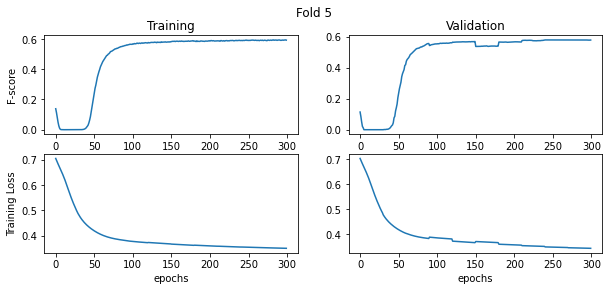

In [7]:
# Compile and train first model on stratified folds
model1.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=[F1])

model1_histories = []
for train_index, test_index in kfold.split(np.zeros(len(y)), y):
    X_cat_train, X_num_train = X_cat[train_index], X_num[train_index]
    y_train = y[train_index]
    X_cat_test, X_num_test = X_cat[test_index], X_num[test_index] 
    y_test = y[test_index]
    history = model1.fit([X_cat_train, X_num_train], y_train, epochs=30, batch_size=64, verbose=0, validation_data=([X_cat_test, X_num_test], y_test))
    model1_histories.append(history)
plot_histories(model1_histories)
F_score = model1_histories[-1].history['F1'][-1]
print("F-score:", F_score)

## Model 2

WindGustDir/WindDir3pm and Cloud9am/Cloud3pm features crossed. The deep network layers have been doubled to 80, 40, and 20 with an additional and 10 neuron layer.

In [8]:
from tensorflow import gather
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, concatenate
from tensorflow.keras.models import Model
import numpy as np

###########################
# Create crossed features #
###########################
cross_columns = [
    ['WindGustDir', 'WindDir3pm'],
    ['Cloud9am', 'Cloud3pm'],
    ['Location']
]
crossed_columns = cross_features(cross_columns)
print(crossed_columns)
X_cat = df[crossed_columns].values

################################
# Construction of wide network #
################################
input_cat = Input(shape=(X_cat.shape[1],))
wide_branch_inputs = []
# Generate wide network embeddings
for i, col in enumerate(crossed_columns):
    # Encode crossed columns
    encoder = LabelEncoder()
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_wide_embed_2')(x)
    wide_branch_inputs.append(x)
# Concatenate wide network embeddings and create layer
wide_branch = concatenate(wide_branch_inputs, name='wide_concat_2')
wide_branch = Dense(units=1, activation='relu', name='wide_combined_2')(wide_branch)



################################
# Construction of deep network #
################################
deep_branch_inputs = []
# Generate deep network embeddings
for i, col in enumerate(crossed_columns):
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_deep_embed_2')(x)
    deep_branch_inputs.append(x)
# Generate deep network continuous inputs
input_num = Input(shape=(X_num.shape[1],))
x = Dense(units=20, activation='relu', name='numeric_2')(input_num)
deep_branch_inputs.append(x)
# Concatenate embeddings and continuous inputs then create dense layers
deep_branch = concatenate(deep_branch_inputs, name='deep_concat_2')
deep_branch = Dense(units=80, activation='relu', name='deep1_2')(deep_branch)
deep_branch = Dense(units=40, activation='relu', name='deep2_2')(deep_branch)
deep_branch = Dense(units=20, activation='relu', name='deep3_2')(deep_branch)
deep_branch = Dense(units=10, activation='relu', name='deep4_2')(deep_branch)



#########################################
# Combination of wide and deep networks #
#########################################
final_branch = concatenate([wide_branch, deep_branch], name='concat_wide_deep_2')
final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
model2 = Model(inputs=[input_cat, input_num], outputs=final_branch)

['WindGustDir_WindDir3pm_int', 'Cloud9am_Cloud3pm_int', 'Location_int']


F-score: 0.6159386038780212


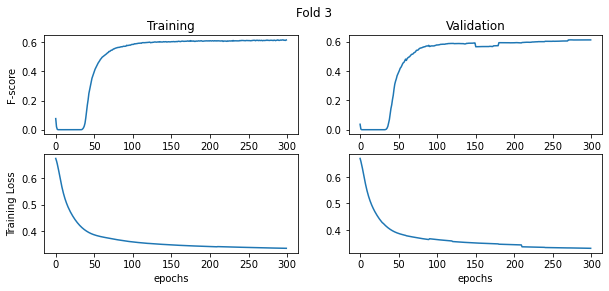

In [9]:
# Compile and train second model on stratified
model2.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=[F1])

model2_histories = []
for train_index, test_index in kfold.split(np.zeros(len(y)), y):
    X_cat_train, X_num_train = X_cat[train_index], X_num[train_index]
    y_train = y[train_index]
    X_cat_test, X_num_test = X_cat[test_index], X_num[test_index] 
    y_test = y[test_index]
    history = model2.fit([X_cat_train, X_num_train], y_train, epochs=30, batch_size=64, verbose=0, validation_data=([X_cat_test, X_num_test], y_test))
    model2_histories.append(history)
plot_histories(model2_histories)
F_score = model2_histories[-1].history['F1'][-1]
print("F-score:", F_score)

## Model 3

All categorical features are crossed with each other. The deep network layers have been doubled again to 160, 80, 40, and 20 with a fifth 10 neuron layer.

In [10]:
from tensorflow import gather
from tensorflow.keras.layers import Dense, Activation, Input, Embedding, concatenate
from tensorflow.keras.models import Model
import numpy as np

###########################
# Create crossed features #
###########################
cross_columns = [
    ["Location", "WindGustDir", "WindDir3pm", "Cloud9am", "Cloud3pm"]
]
crossed_columns = cross_features(cross_columns)
print(crossed_columns)
X_cat = df[crossed_columns].values

################################
# Construction of wide network #
################################
input_cat = Input(shape=(X_cat.shape[1],))
wide_branch_inputs = []
# Generate wide network embeddings
for i, col in enumerate(crossed_columns):
    # Encode crossed columns
    encoder = LabelEncoder()
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_wide_embed_3')(x)
    wide_branch_inputs.append(x)
# There is no need to concatenate with only one input feature
#wide_branch = concatenate(wide_branch_inputs, name='wide_concat_3')
wide_branch = Dense(units=1, activation='relu', name='wide_combined_3')(wide_branch_inputs[0])



################################
# Construction of deep network #
################################
deep_branch_inputs = []
# Generate deep network embeddings
for i, col in enumerate(crossed_columns):
    N = df[col].max() + 1
    x = gather(input_cat, i, axis=1)
    x = Embedding(
            input_dim=N,
            output_dim=int(np.sqrt(N)),
            input_length=1,
            name=col+'_deep_embed_3')(x)
    deep_branch_inputs.append(x)
# Generate deep network continuous inputs
input_num = Input(shape=(X_num.shape[1],))
x = Dense(units=20, activation='relu', name='numeric_3')(input_num)
deep_branch_inputs.append(x)
# Concatenate embeddings and continuous inputs then create dense layers
deep_branch = concatenate(deep_branch_inputs, name='deep_concat_3')
deep_branch = Dense(units=160, activation='relu', name='deep1_3')(deep_branch)
deep_branch = Dense(units=80, activation='relu', name='deep2_3')(deep_branch)
deep_branch = Dense(units=40, activation='relu', name='deep3_3')(deep_branch)
deep_branch = Dense(units=20, activation='relu', name='deep4_3')(deep_branch)
deep_branch = Dense(units=10, activation='relu', name='deep5_3')(deep_branch)



#########################################
# Combination of wide and deep networks #
#########################################
final_branch = concatenate([wide_branch, deep_branch], name='concat_wide_deep_3')
final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)
model3 = Model(inputs=[input_cat, input_num], outputs=final_branch)

['Location_WindGustDir_WindDir3pm_Cloud9am_Cloud3pm_int']


F-score: 0.6024127006530762


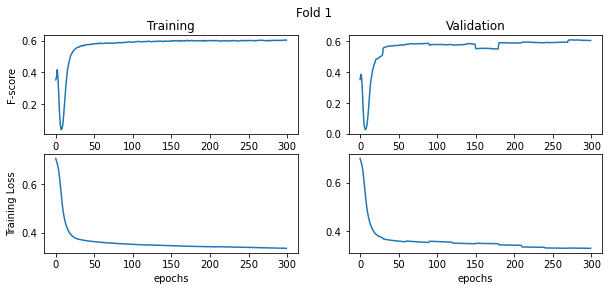

In [11]:
# Compile and train third model on stratified folds
model3.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=[F1])

model3_histories = []
for train_index, test_index in kfold.split(np.zeros(len(y)), y):
    X_cat_train, X_num_train = X_cat[train_index], X_num[train_index]
    y_train = y[train_index]
    X_cat_test, X_num_test = X_cat[test_index], X_num[test_index] 
    y_test = y[test_index]
    history = model3.fit([X_cat_train, X_num_train], y_train, epochs=30, batch_size=64, verbose=0, validation_data=([X_cat_test, X_num_test], y_test))
    model3_histories.append(history)
plot_histories(model3_histories)
F_score = model3_histories[-1].history['F1'][-1]
print("F-score:", F_score)

### Comparison to Multi-Layer Perceptron

When the models are trained to 300 epochs split evenly across all ten folds of the data, the third model performed slightly better than the other two models. The ROC curves of the third model will be compared to that of a Multi-Layer Perceptron, which will also be trained and tested across the stratified folds.

0.6274509803921569
0.6246575342465754
0.6410934744268078
0.6280765724703737
0.6445916114790287
0.6134301270417424
0.6366473473027197
0.6324472960586619
0.6388526727509778
0.6528365791701947
Average of MLP F-scores: 0.634008419533924


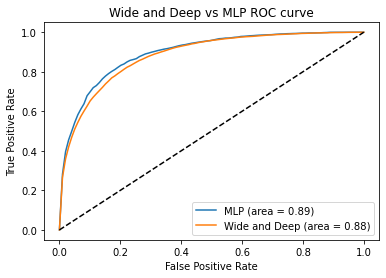

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import f1_score

mlp = MLPClassifier(
    hidden_layer_sizes=(20,),
    learning_rate_init=0.01,
    random_state=1,
    activation='relu'
)

cross_columns = [['Location'], ['WindGustDir'], ['WindDir3pm'], ['Cloud9am'], ['Cloud3pm']]
crossed_columns = cross_features(cross_columns)
X = df[numerical + crossed_columns].values

f1_scores = []
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train and test MLP
    mlp.fit(X_train, y_train)
    yhat = mlp.predict(X_test)

    # Calculate F-score
    f1 = f1_score(y_test, yhat)
    f1_scores.append(f1)
    print(f1)

    # Calculate average true and false positive rates for MLP
    yhat = mlp.predict_proba(X_test)
    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_train)
    for i, c in enumerate(classes):
        fpr, tpr, thresholds = roc_curve(y_test, yhat[:, i], pos_label=c)
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
average_F1 = np.mean(f1_scores)
print("Average of MLP F-scores:", average_F1)

# Plot ROC for MLP
mean_tpr /= 10
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, perclass_mean_tpr, label=f'MLP (area = {mean_auc:0.2f})')

# Rerun prediction for model 3
cross_columns = [["Location", "WindGustDir", "WindDir3pm", "Cloud9am", "Cloud3pm"]]
crossed_columns = cross_features(cross_columns)
X_cat = df[crossed_columns].values
model3_yhat = model3.predict([X_cat, X_num])

# Calculate true and false positive rates for wide and deep network
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
perclass_mean_tpr = 0.0
roc_auc = 0
classes = np.unique(y)
fpr, tpr, thresholds = roc_curve(y, model3_yhat, pos_label=c)
perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
perclass_mean_tpr[0] = 0.0
roc_auc += auc(fpr, tpr)
roc_auc /= len(classes)
mean_tpr += perclass_mean_tpr

# Plot ROC for Wide and Deep Network
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, perclass_mean_tpr, label=f'Wide and Deep (area = {mean_auc:0.2f})')

# Show plot
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Wide and Deep vs MLP ROC curve')
plt.legend(loc='best')

In [16]:
from math import sqrt

def different(e1, n1, e2, n2, z):
    mean = abs(e2 - e1)
    variance = e1 * (1 - e1) / n1 + e2 * (1 - e2) / n2
    lower_bound = mean - z * sqrt(variance)
    upper_bound = mean + z * sqrt(variance)
    if lower_bound < 0 and upper_bound > 0:
        return False
    else:
        return True

n = len(y) // 10
e1 = 1 - 0.5919680595397949
e2 = 1 - 0.6159386038780212
e3 = 1 - 0.6024127006530762
emlp = 1 - 0.634008419533924

print("Model 1 and MLP", "are" if different(e1, n, emlp, n, 1.96) else "are not", "different with 95% confidence.")
print("Model 2 and MLP", "are" if different(e2, n, emlp, n, 1.96) else "are not", "different with 95% confidence.")
print("Model 3 and MLP", "are" if different(e3, n, emlp, n, 1.96) else "are not", "different with 95% confidence.")

Model 1 and MLP are different with 95% confidence.
Model 2 and MLP are different with 95% confidence.
Model 3 and MLP are different with 95% confidence.


As evidenced by the F-scores, the Multi-Layer Perceptron outperforms all three of the models according to the selected evaluation metric. The area under the ROC curves also show slightly greater output quality from the perceptron compared to the third wide and deep network.

## Visualization of Embeddings

Location_int_deep_embed_1
WindGustDir_int_deep_embed_1
WindDir3pm_int_deep_embed_1
Cloud9am_int_deep_embed_1
Cloud3pm_int_deep_embed_1


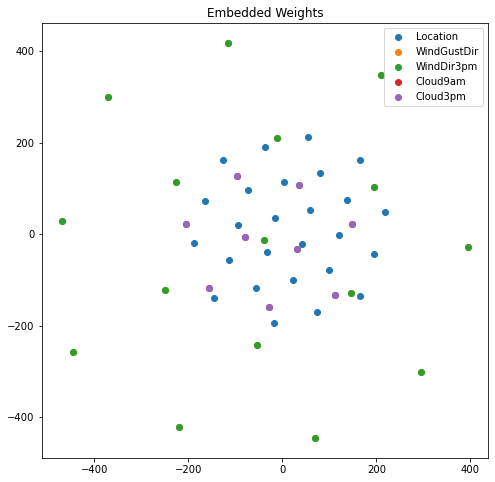

In [13]:
from sklearn.manifold import TSNE

# Save embedded weights
embedded_weights = []
for layer in model1.layers:
    if ('deep_embed' in layer.name):
      print(layer.name)
      embedded_weights.append(layer.get_weights())

# Perform dimensionality reduction on weights
embedded_weights = [w[0] for w in embedded_weights]
tsne = TSNE(n_components=2, random_state=0)
reduced_weights = []
for embedding in embedded_weights:
    tsne_weights = tsne.fit_transform(embedding)
    reduced_weights.append(tsne_weights)

# plot weights
plt.figure(figsize=(8, 8))
for i, w in enumerate(reduced_weights):
    plt.scatter(w[:,0], w[:,1], label=categorical[i])

plt.title('Embedded Weights')
plt.legend(loc='best')
plt.show()

From viewing the graphed features which have been dimensionally reducted using t-distributed Stochastic Neighbor Embedding, it can be seen that the categorical Cloud3pm feature is relatively tightly grouped. Interestingly, the Cloud3pm and Cloud9am features are perfectly imposed on each other. This would indicate that both features are equally poor predictors of whether there will be rain the next day compared to the other categorical features. Additionally, the WindGustDir and WindDir3pm features also occupy the exact same points on the plot. This would indicate that the wind direction of on a particular day is a relatively good predictor of RainTomorrow compared to these other categorical features. The magnitude of the location embedding shows that it is the predictor of all, which depending on one's expectations may be interesting but not surprising.

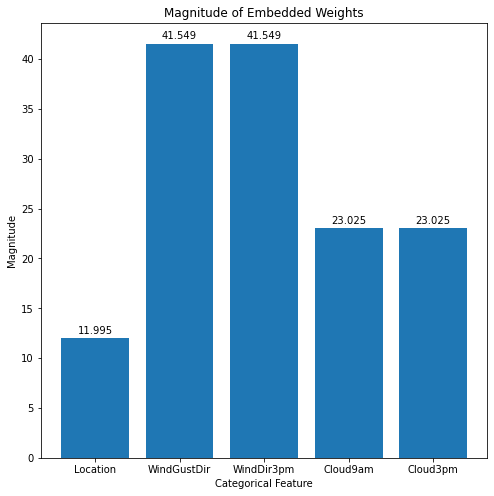

In [14]:
fig, ax = plt.subplots(figsize=(8,8))

# calculate average weights
mean_weights = [np.absolute(np.mean(w)) for w in reduced_weights]
bar = ax.bar(range(len(reduced_weights)), mean_weights)

ax.set_title('Magnitude of Embedded Weights')
ax.set_xlabel('Categorical Feature')
ax.set_ylabel('Magnitude')
ax.set_xticks(range(len(reduced_weights)))
ax.set_xticklabels(categorical)

'''Taken from reference [3]'''
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar)
plt.show()